Extracting data for 79 SNP(s) from 1 GWAS(s)
Harmonising Body mass index || id:ieu-a-2 (ieu-a-2) and Coronary heart disease || id:ieu-a-7 (ieu-a-7)
Analysing 'ieu-a-2' on 'ieu-a-7'
['mr_wald_ratio', 'mr_two_sample_ml', 'mr_egger_regression', 'mr_egger_regression_bootstrap', 'mr_simple_median', 'mr_weighted_median', 'mr_penalised_weighted_median', 'mr_ivw', 'mr_ivw_mre', 'mr_ivw_fe', 'mr_raps', 'mr_sign', 'mr_uwr']
mr_two_sample_ml failed to converge


c:\Users\nkpat\Desktop\MR\mr.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x == 0] = 1
c:\Users\nkpat\Desktop\MR\mr.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x == 0] = 1
C:\Users\nkpat\AppData\Roaming\Python\Python39\site-packages\statsmodels\regression\linear_model.py:921: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
C:\Users\nkpat\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
C:\Users\

[<Axes: xlabel='SNP effect on Body mass index || id:ieu-a-2', ylabel='SNP effect on Coronary heart disease || id:ieu-a-7'>]


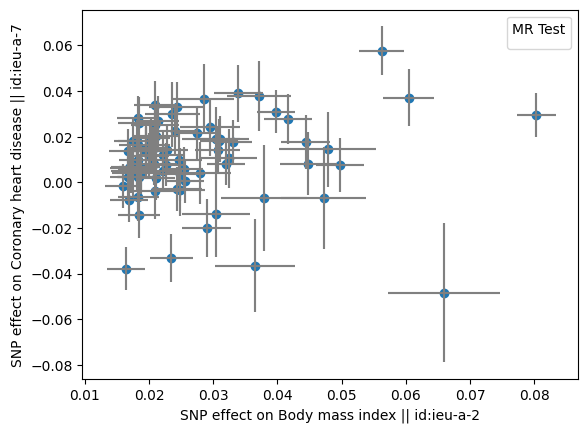

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mr_egger_regression import *
import mr_egger_regression_bootstrap
from mr import *
from extract_instruments import *
import blank_plot
from extract_outcome_data import *
import warnings

def mr_scatter_plot(mr_results, dat):
    res = []

    for group, d in dat.groupby(["id.exposure", "id.outcome"]):
        if len(d) < 2 or sum(d["mr_keep"]) == 0:
            res.append(blank_plot("Insufficient number of SNPs"))
            continue

        d = d[d["mr_keep"]]

        index = d["beta.exposure"] < 0
        d.loc[index, "beta.exposure"] *= -1
        d.loc[index, "beta.outcome"] *= -1

        mrres = mr_results[(mr_results["exposure"] == d["id.exposure"].iloc[0]) & (mr_results["outcome"] == d["id.outcome"].iloc[0])]
        mrres["a"] = 0

        if "MR Egger" in mrres["method"].values:
            temp = mr_egger_regression(d["beta.exposure"], d["beta.outcome"], d["se.exposure"], d["se.outcome"], default_parameters())
            mrres.loc[mrres["method"] == "MR Egger", "a"] = temp.b_i

        if "MR Egger (bootstrap)" in mrres["method"].values:
            temp = mr_egger_regression_bootstrap(d["beta.exposure"], d["beta.outcome"], d["se.exposure"], d["se.outcome"], default_parameters())
            mrres.loc[mrres["method"] == "MR Egger (bootstrap)", "a"] = temp.b_i


        mrres = mrres.sort_values("method")

        plt.figure()
        plt.scatter(d["beta.exposure"], d["beta.outcome"])
        plt.errorbar(x=d["beta.exposure"], y=d["beta.outcome"], xerr=d["se.exposure"], yerr=d["se.outcome"], fmt="none", color="grey")
        plt.errorbar(x=d["beta.exposure"], y=d["beta.outcome"], xerr=d["se.exposure"], yerr=d["se.outcome"], fmt="none", color="grey", alpha=0.5, capsize=0)
        for _, row in mrres.iterrows():
            if row["method"] == "MR Egger":
                plt.plot(d["beta.exposure"], row["a"] + row["b"] * d["beta.exposure"], linestyle='--', label=row["method"])
            else:
                plt.plot(d["beta.exposure"], row["a"] + row["b"] * d["beta.exposure"], label=row["method"])
        plt.xlabel(f"SNP effect on {d['exposure'].iloc[0]}")
        plt.ylabel(f"SNP effect on {d['outcome'].iloc[0]}")
        plt.legend(title="MR Test", loc="upper right")

        res.append(plt.gca())
        warnings.filterwarnings('ignore')
    return res
    

e = extract_instruments("ieu-a-2")
o = extract_outcome_data(snps=e["SNP"], outcomes=["ieu-a-7"])

dat = harmonise_data(e , o)

res = mr(dat)
print (mr_scatter_plot(res,dat))